# This notebook contains the stress testing of the library

In [21]:
import sys
import os

sys.path.append(os.path.abspath("../../project")) 

# Qudit Gates and Random Circuit Generator

In this notebook, we:
- Implement qudit versions of X, Z, H, and CNOT gates.
- Generate a random qudit circuit given a dimension `d` and a number of qudits `n`.
- Visualize the resulting circuit using Cirq's native diagram method.
- Convert the circuit into a graph representation where each gate is a node, and edges represent sequential operations on the same qudit line.
- Visualize the graph using NetworkX and matplotlib.


In [29]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Random Qudit Circuit Generation

We will:
1. Define a set of gates that can be randomly chosen.
2. Create a function to generate `n` qudits (Cirq LineQid objects) each of dimension `d`.
3. Add a random sequence of gates across these qudits.
4. Optionally add a few CNOTs between random pairs of qudits.

The user can control:
- `d`: dimension of each qudit.
- `num_qudits`: number of qudits in the circuit.
- `depth`: number of layers of operations to apply.


In [23]:
from qudit_cirq.circuit_builder import create_circuit
from qudit_cirq.qudit import quditXGate, quditZGate, quditHGate, quditCNOTGate, state_vector, qudit_measure
from qudit_cirq.utils import format_out, printVector, tensor_product

In [24]:
def generate_random_qudit_circuit(d: int, num_qudits: int, depth: int, 
                                  p_two_qudit: float = 0.3, seed: int = None) -> cirq.Circuit:
    if seed is not None:
        np.random.seed(seed)

    qudits = [cirq.LineQid(i, dimension=d) for i in range(num_qudits)]
    
    single_qudit_gates = [
        quditXGate(d),
        quditZGate(d),
        quditHGate(d)
    ]
    
    two_qudit_gate = quditCNOTGate(d)  # CNOT(d)
    
    circuit = cirq.Circuit()

    for _ in range(depth):
        if np.random.rand() < p_two_qudit and num_qudits >= 2:
            # Insert a two-qudit gate at random
            control, target = np.random.choice(num_qudits, size=2, replace=False)
            circuit.append(two_qudit_gate(qudits[control], qudits[target]))
        else:
            # Insert single-qudit gate
            chosen_qudit = np.random.choice(num_qudits)
            gate = np.random.choice(single_qudit_gates)
            if isinstance(gate, quditXGate) or isinstance(gate, quditZGate):
                exponent = np.random.randint(1, d)
                gate = gate.__class__(d, exponent=exponent)
            circuit.append(gate(qudits[chosen_qudit]))

    # Add measurement
    for i, q in enumerate(qudits):
        circuit.append(qudit_measure(q, key=f"m{i}"))

    return circuit


In [26]:
M = 10**6 
depth = 10  
p_two_qudit = 0.3
seed = 42
dimensions = range(2, 21)  

max_qudits_per_dim = []

for d in dimensions:
    N = 0
    while True:
        N_next = N + 1
        if d**N_next <= M:
            circuit = generate_random_qudit_circuit(d, N_next, depth, p_two_qudit, seed)
            N = N_next
            print(circuit)
        else:
            break
    max_qudits_per_dim.append(N)

0 (d=2): ───X^1(d=2)───X^1(d=2)───Z^1(d=2)───H(d=2)───X^1(d=2)───H(d=2)───Z^1(d=2)───Z^1(d=2)───X^1(d=2)───Z^1(d=2)───M('m0')───
0 (d=2): ───H(d=2)───X^1(d=2)───X(d=2)───X(d=2)────────────C(d=2)──────────────C(d=2)───C(d=2)───X^1(d=2)───M('m0')───
                                │        │                 │                   │        │
1 (d=2): ───────────────────────C(d=2)───C(d=2)───H(d=2)───X(d=2)───Z^1(d=2)───X(d=2)───X(d=2)───M('m1')──────────────
0 (d=2): ───H(d=2)───X^1(d=2)───X(d=2)────────────C(d=2)───C(d=2)───H(d=2)───M('m0')───────────────────────
                                │                 │        │
1 (d=2): ───────────────────────C(d=2)───X(d=2)───X(d=2)───┼────────C(d=2)───X^1(d=2)───H(d=2)───M('m1')───
                                         │                 │        │
2 (d=2): ────────────────────────────────C(d=2)────────────X(d=2)───X(d=2)───M('m2')───────────────────────
0 (d=2): ───H(d=2)────X^1(d=2)───X(d=2)───H(d=2)───C(d=2)───H(d=2)───M('m0')────────────

In [28]:
max_qudits_per_dim

[19, 12, 9, 8, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4]

# Visualization

Now we plot the maximum feasible number of qudits vs. dimension.

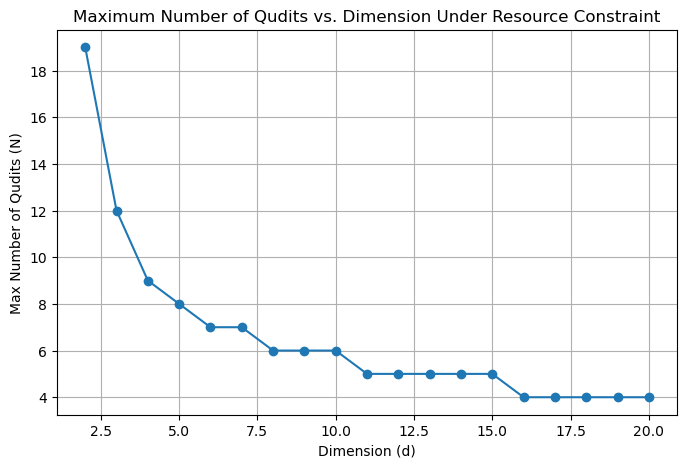

In [27]:

plt.figure(figsize=(8,5))
plt.plot(dimensions, max_qudits_per_dim, marker='o')
plt.title("Maximum Number of Qudits vs. Dimension Under Resource Constraint")
plt.xlabel("Dimension (d)")
plt.ylabel("Max Number of Qudits (N)")
plt.grid(True)
plt.show()
